In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# tickers = ['JNK', 'TLT']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True)   # get dividend adjusted price

In [3]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(1, future_stack=True)
#     .reset_index()
#     [['Date', 'Ticker', 'Close']]
#     .sort_values(by=['Date', 'Ticker'])
# )

# data.head(5)

In [4]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_JNK_TLT_2007-12-04_D.csv', index=False)

In [5]:
# read data from csv
data = pd.read_csv('data_JNK_TLT_2007-12-04_D.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9018 entries, 0 to 9017
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9018 non-null   datetime64[ns]
 1   Ticker  9018 non-null   object        
 2   Close   9018 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 211.5+ KB
None
        Date Ticker      Close
0 2007-12-04    JNK  40.735722
1 2007-12-04    TLT  55.422939
2 2007-12-05    JNK  40.744225
3 2007-12-05    TLT  54.761887
4 2007-12-06    JNK  40.642155


In [6]:
# Add year-month label (end of month date)

# Convert Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'ym' representing the last day of each month
data['ym'] = data['Date'] + pd.offsets.MonthEnd(0)

data.head()

,Date,Ticker,Close,ym
0,2007-12-04,JNK,40.735722,2007-12-31
1,2007-12-04,TLT,55.422939,2007-12-31
2,2007-12-05,JNK,40.744225,2007-12-31
3,2007-12-05,TLT,54.761887,2007-12-31
4,2007-12-06,JNK,40.642155,2007-12-31


In [7]:
# Create trading-day counter for each Ticker and month

# Sort data to ensure correct order
data = data.sort_values(['Ticker', 'Date']).copy()

# Count trading days within each (Ticker, ym) group
data['td'] = data.groupby(['Ticker', 'ym']).cumcount() + 1

data.head()

,Date,Ticker,Close,ym,td
0,2007-12-04,JNK,40.735722,2007-12-31,1
2,2007-12-05,JNK,40.744225,2007-12-31,2
4,2007-12-06,JNK,40.642155,2007-12-31,3
6,2007-12-07,JNK,40.667641,2007-12-31,4
8,2007-12-10,JNK,40.863319,2007-12-31,5


In [8]:
#  Calculate daily simple returns

# Calculate percentage change of 'Close' within each ticker
data['ret'] = data.groupby('Ticker')['Close'].pct_change()

data.head()

,Date,Ticker,Close,ym,td,ret
0,2007-12-04,JNK,40.735722,2007-12-31,1,NaN
2,2007-12-05,JNK,40.744225,2007-12-31,2,0.000209
4,2007-12-06,JNK,40.642155,2007-12-31,3,-0.002505
6,2007-12-07,JNK,40.667641,2007-12-31,4,0.000627
8,2007-12-10,JNK,40.863319,2007-12-31,5,0.004812


In [9]:
# Filter dates and keep only needed columns

# Keep data from August 2002 onwards
data = data[data['Date'] >= pd.Timestamp(2002, 8, 1)]

# Keep only useful columns
data = data[['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]

data.head()

,Date,ym,Ticker,Close,ret,td
0,2007-12-04,2007-12-31,JNK,40.735722,NaN,1
2,2007-12-05,2007-12-31,JNK,40.744225,0.000209,2
4,2007-12-06,2007-12-31,JNK,40.642155,-0.002505,3
6,2007-12-07,2007-12-31,JNK,40.667641,0.000627,4
8,2007-12-10,2007-12-31,JNK,40.863319,0.004812,5


In [10]:
# Create start/end/month flags and conditional returns

N = 15  # number of days for start of month
M = 5   # number of days for next start of month

# Flags: 1 if condition true, 0 otherwise
data['som_flag'] = (data['td'] <= N).astype(int)
data['eom_flag'] = (data['td'] > N).astype(int)
data['nsm_flag'] = (data['td'] <= M).astype(int)

# Conditional returns (return only within flag period)
data['ret_som'] = data['ret'] * data['som_flag']
data['ret_eom'] = data['ret'] * data['eom_flag']
data['ret_nsm'] = data['ret'] * data['nsm_flag']

# backward fill NaN returns with 0
data['ret_som'] = data['ret_som'].fillna(0)

data.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
0,2007-12-04,2007-12-31,JNK,40.735722,NaN,1,1,0,1,0.000000,NaN,NaN
2,2007-12-05,2007-12-31,JNK,40.744225,0.000209,2,1,0,1,0.000209,0.0,0.000209
4,2007-12-06,2007-12-31,JNK,40.642155,-0.002505,3,1,0,1,-0.002505,-0.0,-0.002505
6,2007-12-07,2007-12-31,JNK,40.667641,0.000627,4,1,0,1,0.000627,0.0,0.000627
8,2007-12-10,2007-12-31,JNK,40.863319,0.004812,5,1,0,1,0.004812,0.0,0.004812


In [11]:
# Keep only relevant return columns
data_flags = data[['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]

data_flags.head()

,Date,ym,Ticker,ret_som,ret_eom,ret_nsm
0,2007-12-04,2007-12-31,JNK,0.000000,NaN,NaN
2,2007-12-05,2007-12-31,JNK,0.000209,0.0,0.000209
4,2007-12-06,2007-12-31,JNK,-0.002505,-0.0,-0.002505
6,2007-12-07,2007-12-31,JNK,0.000627,0.0,0.000627
8,2007-12-10,2007-12-31,JNK,0.004812,0.0,0.004812


In [12]:
# Pivot to wide format (one column per Ticker)

# Create wide format table: columns for each Ticker and return type
pivoted = data_flags.pivot(index=['Date', 'ym'], columns='Ticker')

# Flatten multi-level column names (e.g. ret_som_SPY)
pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

pivoted = pivoted.reset_index()

pivoted.head()

,Date,ym,JNK_ret_som,TLT_ret_som,JNK_ret_eom,TLT_ret_eom,JNK_ret_nsm,TLT_ret_nsm
0,2007-12-04,2007-12-31,0.000000,0.000000,NaN,NaN,NaN,NaN
1,2007-12-05,2007-12-31,0.000209,-0.011927,0.0,-0.0,0.000209,-0.011927
2,2007-12-06,2007-12-31,-0.002505,-0.008759,-0.0,-0.0,-0.002505,-0.008759
3,2007-12-07,2007-12-31,0.000627,-0.011208,0.0,-0.0,0.000627,-0.011208
4,2007-12-10,2007-12-31,0.004812,-0.005994,0.0,-0.0,0.004812,-0.005994


In [13]:
# create a copy of data to be later used for the backtest analysis (8 PL streams in the backtesting)
backtest_data = pivoted.copy()

In [14]:
# Compute relative returns and aggregate monthly

# Calculate combined and relative returns
pivoted['JNK_ret'] = pivoted['JNK_ret_som'] + pivoted['JNK_ret_eom']
pivoted['JNK_TLT_som'] = pivoted['JNK_ret_som'] - pivoted['TLT_ret_som']
pivoted['JNK_TLT_eom'] = pivoted['JNK_ret_eom'] - pivoted['TLT_ret_eom']
pivoted['JNK_TLT_nsm'] = pivoted['JNK_ret_nsm'] - pivoted['TLT_ret_nsm']

# Add TLT_ret column
pivoted['TLT_ret'] = pivoted['TLT_ret_som'] + pivoted['TLT_ret_eom']

# Select relevant columns
returns = pivoted[['ym', 'JNK_ret', 'JNK_TLT_som', 'JNK_TLT_eom', 'JNK_TLT_nsm', 'TLT_ret']]

# Aggregate monthly returns using compounding formula
monthly = returns.groupby('ym').apply(lambda x: (1 + x).prod() - 1)

monthly.head()

,JNK_ret,JNK_TLT_som,JNK_TLT_eom,JNK_TLT_nsm,TLT_ret
ym,,,,,
2007-12-31,0.006991,0.036360,-0.016374,0.041656,-0.013996
2008-01-31,-0.023398,-0.073021,0.029511,-0.024152,0.020958
2008-02-29,-0.034403,-0.000566,-0.031486,-0.000718,-0.004552
2008-03-31,0.004647,-0.023398,0.004746,0.018015,0.021387
2008-04-30,0.037240,0.051203,0.010680,0.017045,-0.024862


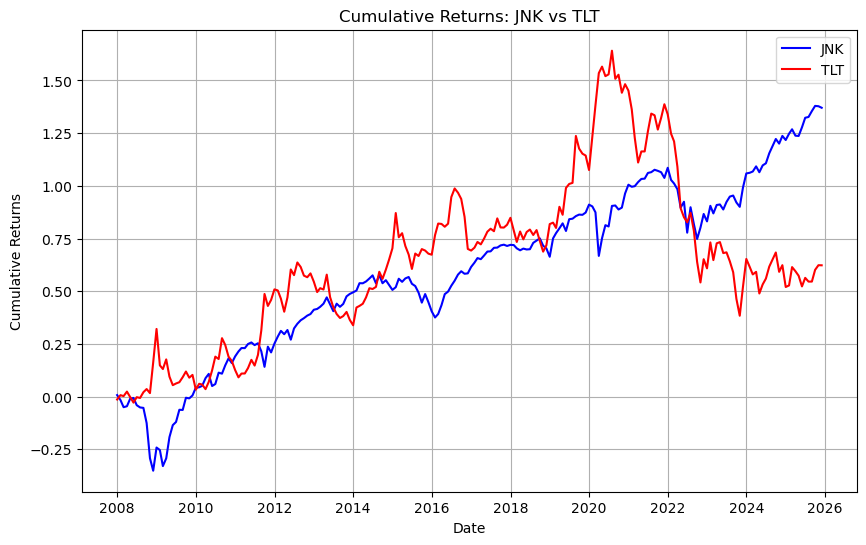

In [15]:
# calculate cumulative returns for JNK_ret and TLT_ret
monthly['JNK_cumret'] = (1 + monthly['JNK_ret']).cumprod() - 1
monthly['TLT_cumret'] = (1 + monthly['TLT_ret']).cumprod() - 1

# plot JNK_ret vs TLT_ret to compare their performance
plt.figure(figsize=(10, 6))
plt.plot(monthly.index, monthly['JNK_cumret'], label='JNK', color='blue')
plt.plot(monthly.index, monthly['TLT_cumret'], label='TLT', color='red')
plt.title('Cumulative Returns: JNK vs TLT')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

In [17]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2007-12-31 to 2025-11-30
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   JNK_ret      216 non-null    float64
 1   JNK_TLT_som  216 non-null    float64
 2   JNK_TLT_eom  216 non-null    float64
 3   JNK_TLT_nsm  216 non-null    float64
 4   TLT_ret      216 non-null    float64
 5   JNK_cumret   216 non-null    float64
 6   TLT_cumret   216 non-null    float64
dtypes: float64(7)
memory usage: 13.5 KB


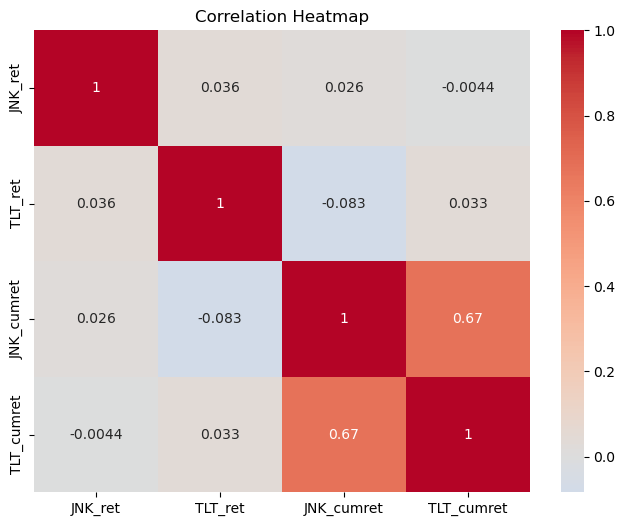

In [18]:
# plot correlation heatmap of JNK_ret, TLT_ret, JNK_cumret, TLT_cumret
plt.figure(figsize=(8, 6))
sns.heatmap(monthly[['JNK_ret', 'TLT_ret', 'JNK_cumret', 'TLT_cumret']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
return_data = monthly.copy()